## Rule-Based Market Regime Determination Algorithms

In [1]:
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import os
from tqdm import tqdm
import math
import ta

import logging.config
logging.config.dictConfig({'version': 1, 'disable_existing_loggers': True})

In [2]:
df = pd.read_csv('/home/lmilo_ext/Data/prepared_data.csv')
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df.head()

,AdrActCnt,AdrBal1in100KCnt,AdrBal1in10KCnt,AdrBal1in10MCnt,AdrBal1in1KCnt,AdrBal1in1MCnt,AdrBalNtv100Cnt,AdrBalNtv100KCnt,AdrBalNtv10Cnt,AdrBalNtv10KCnt,...,NVT Ratio (with Transaction Volume)_btc,Circulation NVT_btc,Realized Cap_btc,Realized Cap (7d)_btc,Realized Cap (30d)_btc,Realized Cap (90d)_btc,Realized Cap (60d)_btc,Realized Cap (180d)_btc,Realized Cap (365d)_btc,Stock to Flow ratio_btc
date,,,,,,,,,,,,,,,,,,,,,
2017-01-02,2.759253e+06,248441.000000,47491.857143,5.049924e+06,6119.000000,1.518931e+06,4.154845e+06,141332.428571,8.292783e+06,6.065049e+05,...,11.497847,48.017291,6.879978e+09,8.826018e+08,1.656658e+09,2.542547e+09,2.175202e+09,3.259974e+09,4.264022e+09,23.050918
2017-01-09,9.889732e+06,871727.857143,166387.428571,1.767255e+07,21509.857143,5.316332e+06,1.454555e+07,494483.857143,2.903374e+07,2.124377e+06,...,11.497847,48.017291,6.879978e+09,8.826018e+08,1.656658e+09,2.542547e+09,2.175202e+09,3.259974e+09,4.264022e+09,23.050918
2017-01-16,9.845421e+06,876928.142857,166228.000000,1.767422e+07,21499.857143,5.314798e+06,1.456219e+07,494053.714286,2.906592e+07,2.124969e+06,...,11.135487,52.253038,6.952027e+09,8.584415e+08,1.747843e+09,2.640501e+09,2.259350e+09,3.337645e+09,4.339008e+09,23.206170
2017-01-23,9.841003e+06,882297.857143,166445.000000,1.771058e+07,21526.428571,5.318879e+06,1.456741e+07,493311.142857,2.908759e+07,2.122200e+06,...,13.263055,62.507007,6.977276e+09,6.752914e+08,1.736224e+09,2.654568e+09,2.270288e+09,3.359355e+09,4.354986e+09,23.586007
2017-01-30,1.004979e+07,886092.142857,166745.857143,1.772873e+07,21664.285714,5.324168e+06,1.453396e+07,493560.142857,2.906041e+07,2.121745e+06,...,15.584666,59.141003,7.051892e+09,6.443858e+08,1.723002e+09,2.694323e+09,2.305593e+09,3.404450e+09,4.415296e+09,22.095225


### Pagan & Sossounov 

In [3]:
df_pagan = df.copy()

# Define the parameters
tau_window = 4
tau_cycle = 6
tau_phase = 8
zeta = 0.2
tau_censor = 13

# Step 1: Identify local maxima and minima
df_pagan['LocalMax'] = df_pagan['ReferenceRate'].rolling(window=tau_window+1, center=True).max()
df_pagan['LocalMin'] = df_pagan['ReferenceRate'].rolling(window=tau_window+1, center=True).min()

# Step 2: Enforcement of alternation
# Select the highest of multiple peaks (or lowest of multiple troughs)
df_pagan['TurningPoint'] = np.where((df_pagan['ReferenceRate'] == df_pagan['LocalMax']), 1, np.where((df_pagan['ReferenceRate'] == df_pagan['LocalMin']), -1, 0))
df_pagan['TurningPoint'] = df_pagan['TurningPoint'].fillna(0)  # Fill NaN values with 0
df_pagan['TurningPoint'] = df_pagan['TurningPoint'].replace(0, np.nan)  # Convert 0 values to NaN
df_pagan['TurningPoint'] = df_pagan['TurningPoint'].fillna(method='ffill')  # Forward-fill NaN values

# Step 3a: Censoring operations - Eliminate turns within 13 weeks of beginning and end
df_pagan.loc[:tau_censor-1, 'TurningPoint'] = 0
df_pagan.loc[-tau_censor:, 'TurningPoint'] = 0

# Step 3b: Eliminate peaks (or troughs) at both ends of the series
df_pagan.loc[(df_pagan['TurningPoint'] == 1) & (df_pagan['ReferenceRate'] == df_pagan['ReferenceRate'].iloc[0]), 'TurningPoint'] = 0
df_pagan.loc[(df_pagan['TurningPoint'] == -1) & (df_pagan['ReferenceRate'] == df_pagan['ReferenceRate'].iloc[-1]), 'TurningPoint'] = 0

# Step 3c: Eliminate cycles whose duration is less than 6 weeks
df_pagan['Cycle'] = df_pagan['TurningPoint'].cumsum()
df_pagan['CycleDuration'] = df_pagan.groupby('Cycle')['Cycle'].transform('count')
df_pagan.loc[df_pagan['CycleDuration'] < tau_cycle, 'TurningPoint'] = 0

# Step 3d: Eliminate phases whose duration is less than 8 weeks (unless fall/rise exceeds 20%)
df_pagan['Phase'] = df_pagan['TurningPoint'].cumsum()
df_pagan['PhaseDuration'] = df_pagan.groupby('Phase')['Phase'].transform('count')
price_change = df_pagan['ReferenceRate'].pct_change()
df_pagan.loc[(df_pagan['PhaseDuration'] < tau_phase) & (abs(price_change) >= zeta), 'TurningPoint'] = 0

# Step 4: Final turning points
df_pagan['MarketRegime'] = np.where(df_pagan['TurningPoint'] == 1, 'Bull', np.where(df_pagan['TurningPoint'] == -1, 'Bear', None))
df_pagan['MarketRegime'] = df_pagan['MarketRegime'].fillna(method='ffill')
df_pagan['MarketRegime'] = df_pagan['MarketRegime'].fillna(method='bfill') 

# Clean up intermediate columns
df_pagan.drop(['LocalMax', 'LocalMin', 'TurningPoint', 'Cycle', 'CycleDuration', 'Phase', 'PhaseDuration'], axis=1, inplace=True)

/tmp/ipykernel_3334229/1884218407.py:25: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df_pagan.loc[:tau_censor-1, 'TurningPoint'] = 0
/tmp/ipykernel_3334229/1884218407.py:26: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df_pagan.loc[-tau_censor:, 'TurningPoint'] = 0


In [4]:
df_pagan[['target']] = df_pagan[['ReferenceRate']].pct_change().shift(-1)
df_pagan.groupby('MarketRegime').agg({'target':['mean', 'std', 'count']})

target                
                  mean       std count
MarketRegime                          
Bear          0.063587  0.186168   174
Bull         -0.038366  0.090711   158

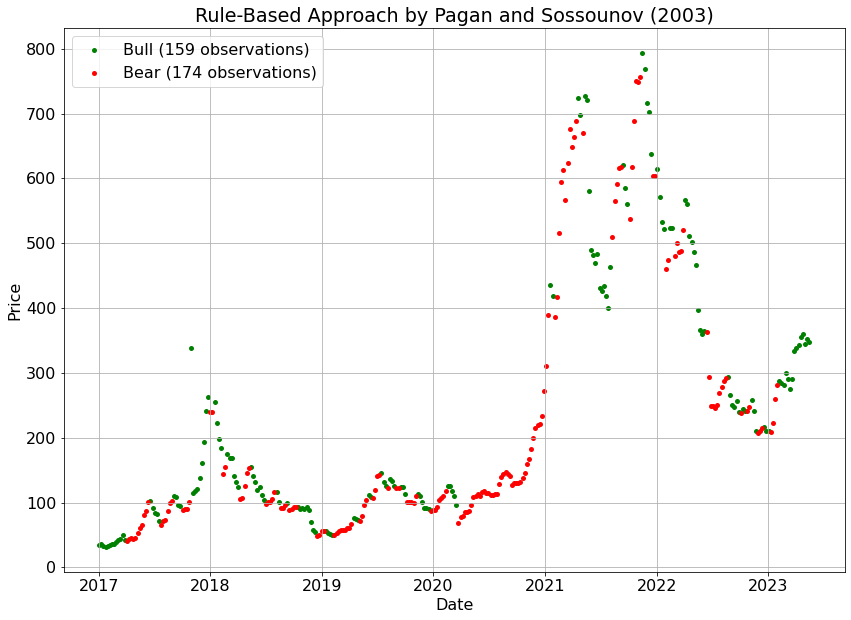

In [5]:
# Define colors for each regime
colors = {'Bull': 'green', 'Bear': 'red'}

# Create a figure
plt.figure(figsize=(14, 10))
plt.rcParams.update({'font.size': 16})

# Iterate over regimes and plot each one separately
for regime, color in colors.items():
    regime_indices = df_pagan[df_pagan['MarketRegime'] == regime].index
    plt.scatter(regime_indices, df_pagan.loc[regime_indices, 'ReferenceRate'], c=color, label=f'{regime} ({len(regime_indices)} observations)', linewidth=3, s=4)

plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.legend()
plt.title('Rule-Based Approach by Pagan and Sossounov (2003)')
plt.savefig(fname='Passan', dpi = 300, bbox_inches='tight', pad_inches = 0.025)
plt.show()

### Crossing SMA

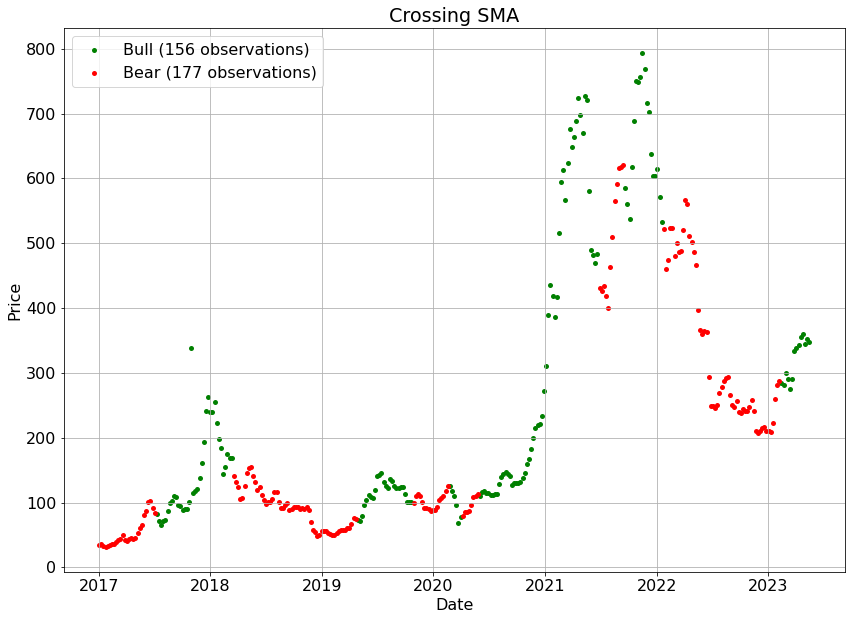

In [6]:
df_sma = df.copy()

# Calculate the short-term and long-term moving averages (e.g., 50-day and 200-day SMAs)
df_sma['sma_50'] = ta.trend.sma_indicator(df_sma['ReferenceRate'], window=7)
df_sma['sma_200'] = ta.trend.sma_indicator(df_sma['ReferenceRate'], window=28)

# Create market regime labels based on SMA crossovers
df_sma['MarketRegime'] = 'Bear'
df_sma.loc[df_sma['sma_50'] > df_sma['sma_200'], 'MarketRegime'] = 'Bull'



# Define colors for each regime
colors = {'Bull': 'green', 'Bear': 'red'}  # Adjust colors as needed

# Plot scatter points for market regimes
plt.figure(figsize=(14, 10))
for regime, color in colors.items():
    mask = df_sma['MarketRegime'] == regime
    # Plot the Bull or Bear regime
    regime_indices = df_sma[df_sma['MarketRegime'] == regime].index
    plt.scatter(df_sma.index[mask], df_sma['ReferenceRate'][mask], c=color, label=f'{regime} ({len(regime_indices)} observations)', linewidth=3, s=4)

plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.title('Crossing SMA')
plt.legend()
plt.savefig(fname='SMA', dpi = 300, bbox_inches='tight', pad_inches = 0.025)
plt.show()

In [7]:
df_sma[['target']] = df_sma[['ReferenceRate']].pct_change().shift(-1)
df_sma.groupby('MarketRegime').agg({'target':['mean', 'std', 'count']})

target                
                  mean       std count
MarketRegime                          
Bear          0.005485  0.074330   177
Bull          0.026010  0.215343   155

### Lunde & Timmermann

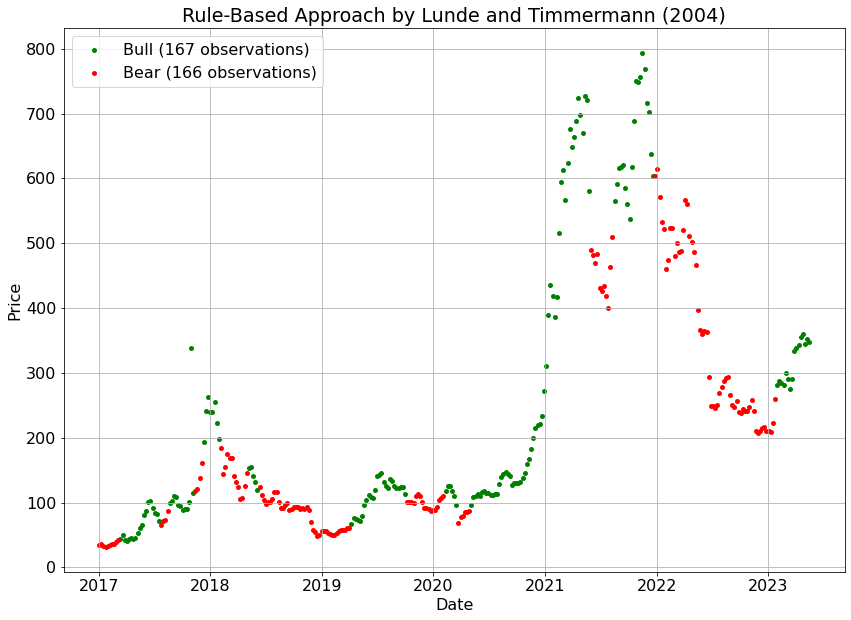

In [8]:
df_lunde = df.copy()

# Parameters
lambda1 = 0.25  # Fraction for peak detection
lambda2 = 0.2  # Fraction for trough detection

# Initialize variables
Pmax = None
Pmin = None
bullish_start = None  # Use None instead of False for better tracking
regimes = []  # Initialize with an empty list

# Iterate through the DataFrame
for index, row in df_lunde.iterrows():
    Pt = row['ReferenceRate']
    
    if Pmax is None or Pmin is None:
        Pmax = Pt
        Pmin = Pt
        bullish_start = True if Pt > Pmin else False

    if bullish_start:
        regimes.append('Bull')
        if Pt > Pmax:
            Pmax = Pt
        elif Pt < Pmax - lambda2 * Pmax:
            Pmin = Pt
            bullish_start = False
    else:
        regimes.append('Bear')
        if Pt < Pmin:
            Pmin = Pt
        elif Pt > Pmin + lambda1 * Pmin:
            Pmax = Pt
            bullish_start = True

# Update the DataFrame with the calculated regimes
df_lunde['MarketRegime'] = regimes

plt.rcParams.update({'font.size': 16})

# Define colors for each regime
colors = {'Bull': 'green', 'Bear': 'red'}

# Create a figure
plt.figure(figsize=(14, 10))

# Iterate over regimes and plot each one separately
for regime, color in colors.items():
    regime_indices = df_lunde[df_lunde['MarketRegime'] == regime].index
    plt.scatter(regime_indices, df_lunde.loc[regime_indices, 'ReferenceRate'], c=color, label=f'{regime} ({len(regime_indices)} observations)', linewidth=3, s=4)

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Rule-Based Approach by Lunde and Timmermann (2004)')
plt.grid(True)
plt.legend()
plt.savefig(fname='Lunde', dpi = 300, bbox_inches='tight', pad_inches = 0.025)
plt.show()

In [9]:
df_lunde[['target']] = df_lunde[['ReferenceRate']].pct_change().shift(-1)
df_lunde.groupby('MarketRegime').agg({'target':['mean', 'std', 'count']})

target                
                  mean       std count
MarketRegime                          
Bear          0.004597  0.077179   166
Bull          0.025538  0.207866   166